In [1]:
import RMS_utils
train_dir, validation_dir, class_weight = RMS_utils.prep_dir("RMS Trichrome/")

No. ARMS Train: 105
No. ERMS Train: 301
No. ARMS Validation: 43
No. ERMS Validation: 148


In [2]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import layers, models, activations

conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
#model.add(layers.Activation(activations.relu))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
dense (Dense)                (None, 4, 4, 1024)        1573888   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [3]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model.compile(optimizer = Adam(lr=0.00007), 
              loss = 'binary_crossentropy', 
              metrics = ['AUC'])

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                   rotation_range = 360,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.0,
                                   shear_range = 0.0,
                                   zoom_range = 0.0,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode='wrap')

train_generator, validation_generator = RMS_utils.prep_datagen(train_dir, validation_dir, train_datagen, 10, 200)

Found 406 images belonging to 2 classes.
Found 191 images belonging to 2 classes.


In [4]:
history = model.fit(train_generator,
                            validation_data = validation_generator,
                            #steps_per_epoch = 20,
                            epochs = 1,
                            #validation_steps = 5,
                            verbose = 1,
                            class_weight=class_weight
                            #callbacks=[tensorboard_callback]
                            #callbacks=[learning_rate_reduction]
                   )

41/41 [==============================] - 12s 297ms/step - loss: 0.4112 - auc: 0.5075 - val_loss: 0.4223 - val_auc: 0.8461


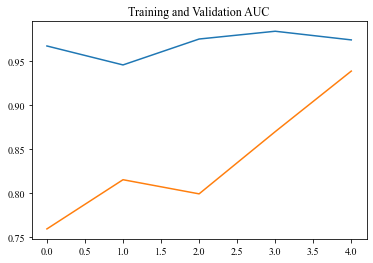

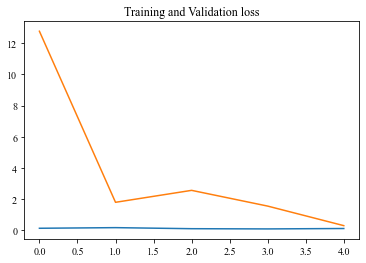

In [14]:
RMS_utils.show_results(history, save = False)

In [5]:
RMS_utils.show_preds(model, validation_generator)

Confusion Matrix
[[ 40   3]
 [122  26]]
              precision    recall  f1-score   support

        ARMS       0.25      0.93      0.39        43
        ERMS       0.90      0.18      0.29       148

    accuracy                           0.35       191
   macro avg       0.57      0.55      0.34       191
weighted avg       0.75      0.35      0.32       191



In [ ]:
#Save Model to use in visualisations and get auc
import pickle

model.save('Saved Model - trichrome')
with open('Saved Model History - trichrome', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

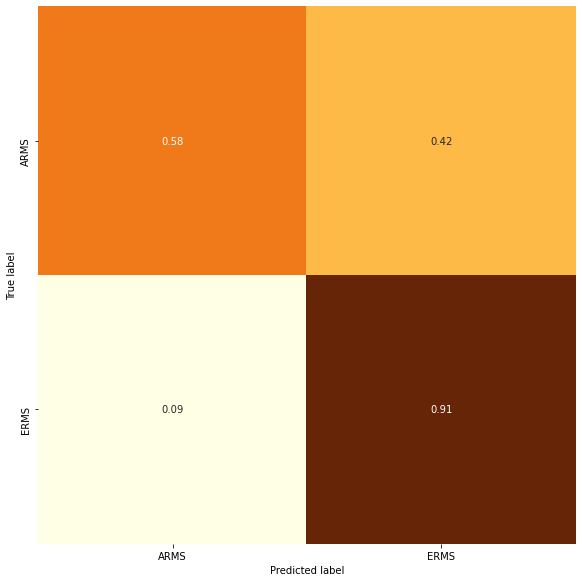

In [6]:
RMS_utils.show_heatmap(model, validation_generator, save=True)